# GlyTrait for Machine Learning

From a data science point of view, derived trait calculation could be regarded as 
a feature engineering step in a machine learning pipeline.
Specifically, we convert the original glycan abundance dimension into the new derived trait dimension.
As derived traits are more biologically interpretable,
we could use derived traits instead of glycan abundance for modeling.
By leveraging model expaination or interpretation techniques,
the models could also be scrutinized for more insights.

Here we demonstrate how to use GlyTrait to calculate derived traits for machine learning.
We use the dataset in glycoPOST (https://glycopost.glycosmos.org/entry/GPST000313).
For simplicity, we only calculate several derived traits here.

In [1]:
#!conda install -c conda-forge scikit-learn shap

## Derived trait calculation

In [2]:
import pandas as pd
from glytrait import Experiment

In [3]:
# If you run this notebook in your environment, you might need to modify the file paths below.
exp = Experiment(
    abundance_file="../example_data/abundance.csv",
    glycan_file="../example_data/structures.csv",
    sia_linkage=True,  # Set to True here to enable sialic acid linkage traits
)

In [4]:
exp.preprocess()  # Calling the step method instead of `run_workflow`

Here we use the `try_formulas` method to get derived trait table directly.
This method is handy for trying new formula expressions,
or to get a fast insight of the data.

In [5]:
formula_exprs = [
    # TM: proportion of high-mannose glycans
    "TM = [type == 'high_mannose'] / [1]",
    # THy: proportion of hybrid glycans
    "THy = [type == 'hybrid'] / [1]",
    # CA1 - CA4: proportion of mono-, bi-, tri-, and tetra-antennary glycans within complex ones
    "CA1 = [nAnt == 1] // [type == 'complex']",
    "CA2 = [nAnt == 2] // [type == 'complex']",
    "CA3 = [nAnt == 3] // [type == 'complex']",
    "CA4 = [nAnt == 4] // [type == 'complex']",
    # TS, TE, TL: propotion of sialylated, a2,6-linked sialylated, and a2,3-linked sialylated glycans
    "TS = [nS > 0] / [1]",
    "TE = [nE > 0] / [1]",
    "TL = [nL > 0] / [1]",
    # TFc, TFa: proportion of core-, and antenna-fucosylated glycans
    "TFc = [nFc > 0] / [1]",
    "TFa = [nFa > 0] / [1]",
    # TB: proportion of bisecting glycans
    "TB = [B] / [1]",
    # SG, EG, LG: average number of sialic acids, a2,6-linked SAs, and a2,3-linked SAs per galactose
    "SG = [nS / nG] // [nG > 0]",
    "EG = [nE / nG] // [nG > 0]",
    "LG = [nL / nG] // [nG > 0]",
]
derived_traits = exp.try_formulas(formula_exprs)
derived_traits.head()

,TM,THy,CA1,CA2,CA3,CA4,TS,TE,TL,TFc,TFa,TB,SG,EG,LG
Sample,,,,,,,,,,,,,,,
S001,0.008032,0.006020,0.011935,0.824623,0.146597,0.016845,0.859404,0.849752,0.188935,0.342337,0.004314,0.046414,0.823177,0.734037,0.089139
S030,0.008745,0.003318,0.009399,0.668274,0.287619,0.034708,0.954978,0.948910,0.239489,0.171842,0.001653,0.034071,0.848082,0.745628,0.102454
S020,0.010453,0.006647,0.011980,0.803622,0.168459,0.015939,0.670194,0.659377,0.182995,0.453135,0.003686,0.077649,0.710516,0.609692,0.100824
S038,0.004888,0.004867,0.009449,0.779131,0.195171,0.016248,0.947958,0.940003,0.242882,0.132130,0.001362,0.017533,0.892381,0.787248,0.105133
A003,0.009935,0.003908,0.010265,0.834835,0.143568,0.011332,0.843867,0.836564,0.139167,0.293333,0.001439,0.050608,0.809640,0.747022,0.062619


## Prepare data for ML

In [6]:
groups = pd.read_csv("../example_data/groups.csv", index_col=0).squeeze()
groups.unique()

array(['Visceral Leishmaniasis', 'Asymptomatic',
       'Healthy from Endemic area'], dtype=object)

In [7]:
groups = groups == "Visceral Leishmaniasis"  # Combine 'Asymptomatic' and 'Healthy from Endemic area'
groups.unique()

array([ True, False])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    derived_traits, groups, test_size=0.3, stratify=groups, shuffle=True, random_state=42
)
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 416
Test size: 179


## Model selection

Here we try several machine learning algorithms for performance benchmark.
Algorithms to use: Logistic Regression, Support Vector Machine, Random Forest.
The models are evaluated on the trian set using 10-fold cross-validation by F1-score.
Neither accuracy or ROC AUC are used because the dataset is slightly imbalanced.
F1-score reflects the classification power of the positive samples more accurately in these situations.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
svm = make_pipeline(StandardScaler(), SVC(random_state=42))
rf = RandomForestClassifier(n_estimators=1000, random_state=42)

lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
svm_scores = cross_val_score(svm, X_train, y_train, cv=10, scoring="f1")
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")

print(f"LR: {lr_scores.mean():.3f} +- {lr_scores.std():.3f}")
print(f"SVM: {svm_scores.mean():.3f} +- {svm_scores.std():.3f}")
print(f"RF: {rf_scores.mean():.3f} +- {rf_scores.std():.3f}")

LR: 0.788 +- 0.097
SVM: 0.764 +- 0.091
RF: 0.763 +- 0.073


It seems that Logistic Regression performed the best. 
This might be due to the rather simple feature dimension we used.
Now we will train the model on the whole train set and evaluate its performance on the test set.

In [10]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")

Accuracy: 0.860
ROC AUC: 0.839
F1-score: 0.779


## Model explaination

As Logistic Regression is a "white-box" model,
we first look at its coefficients to get a gist of how each derived traits affected the model

In [11]:
feature_coefs = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lr["logisticregression"].coef_.reshape(-1),
})
feature_coefs

,feature,coef
0,TM,-0.461379
1,THy,0.244546
2,CA1,-0.654037
3,CA2,0.005260
4,CA3,-0.410786
5,CA4,1.351729
6,TS,-1.197162
7,TE,-0.538681
8,TL,-1.343513
9,TFc,1.294944


The feature had been standarized before fed into the model.
Therefore, the absolute values of the coefficients could reflect feature importance,
while the signs reflect the influence direction of the feature.

From the result above, we could tell that CA4, TS, TL, TFc, SG and LG had large impacts on the model.
A higher value of CA4, TFc, SG, and LG pushed the model to make positive predictions,
while TS and TL had the opposite impact.

Next, we use the SHAP (SHapley Additive exPlanations) algorithm to explain the predictions of the model.
In our simple case, using SHAP seems a little too much.
However, this method is model-agostic to be adopted in any more complex situations.
We demonstrate the method here just for instructional purposes.

In [12]:
import shap

explainer = shap.Explainer(lr.predict, X_train)
shap_values = explainer(X_test)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


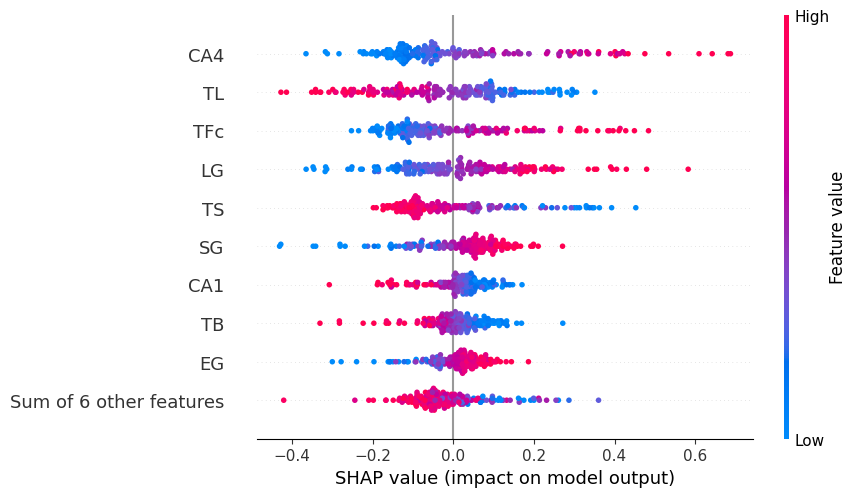

In [13]:
shap.plots.beeswarm(shap_values)

From the plot above, we could get the same conclusion as before.
CA4, TL, TFc, LG, TS and SG have the largest impact on model predictions.